In [297]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold


PERCENTILES = [1, 5, 10, 15, 20] # Top 1%, 5%, 10%, 15%, 20% of predictions
ITERATIONS = 100  # Bootstrap iterations
COLORS = ['#323694', '#039573', '#feea2a'] # Color palette for the classifiers


# CMIM ranking of features 
CMIM_SC_NO_GENPROT = ['paralagous_count', 'upstream_size',  'CAI', 'GLU',
                'aromaticity_score', 'Gravy_score', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG',  'Codon_bias']

CMIM_SC_GENPROT = ['phyletic_retention', 'paralagous_count', 'upstream_size',  'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG']

CMIM_SC_ALL = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus',
                'nucleus', 'upstream_size', 'spindle pole', 'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
                'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP',
                'ER to Golgi', 'GLN', 'peroxisome', 'num places loc', 'LYS',
                'ambiguous', 'cell periphery', 'FOP_score', 'nuclear periphery', 'ARG',
                'Golgi to ER', 'punctate composite', 'ER', 'lipid particle', 'microtubule',
                'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']


## `EssentiallyClassifier` Class

The `EssentiallyClassifier` class is an abstract base class designed to be implemented by diffent classifiers algorithms provviding a common interface for all classifiers.

In [298]:

class EssentiallyClassifier:
    """
    Abstract class for the essentiality classifier.
    Contains the main methods to load the data, find the optimal number of features and plot the results.
    """

    def __init__(self, file_path, cmim_ranking, percentiles,name, skip_discretization=False):
        self.name = name # Name of classifier
        self.file_path = file_path # Path to the excel file
        self.cmim_ranking = cmim_ranking # CMIM ranking of features 
        self.percentiles = percentiles # Top percentiles 
        self.X = None # Features
        self.y = None # Labels of Grand truth
        self.optimal_features = None # Optimal number of features to use
        self.highest_ppv_5 = 0 # Highest PPV (5%), used to find optimal number of features 
        self.final_ppv_scores = [] # Final PPV scores for the top percentiles
        self.final_fpr = [] # Final FPR scores
        self.final_tpr = [] # Final TPR scores
        self.final_auc = None # Final AUC score
        self.categories = None # Number of unique categories in the data
        self.skip_discretization = skip_discretization # Load the data without discretization


    def load_data(self):
        """
        Loads the data with the specified method.
        """
        self.load_discretized_data() if not self.skip_discretization else self.load_raw_data()


    def load_raw_data(self):
        """
        Loads the data without discretization.
        """
        data = pd.read_excel(self.file_path)
        self.X = data.drop(columns=['Essential', 'orf_id'])
        self.y = data['Essential']

        print("Row data loaded successfully, shape:", self.X.shape, self.y.shape)
        self.X.to_excel(f'./output/{self.name}_processed_features_.xlsx', index=False)
        print("Data saved successfully");

    def load_discretized_data(self):
        """
        Loads and processes discretized data from an Excel file.
        Reads data and uses a label encoder to convert symbols to integers.
        Counts the number of unique categories in the data.
        """
        discretized_data = pd.read_excel(self.file_path, sheet_name='entropy discretized')
        columns_with_symbols = discretized_data.columns[2:]
        label_encoders = {}

        for column in columns_with_symbols:
            le = LabelEncoder()
            discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
            label_encoders[column] = le

        self.X = discretized_data.drop(columns=['Essential', 'orf_id'])
        self.y = discretized_data['Essential']

        # Count the number of unique categories in the data
        min_categories = self.X.nunique()
        self.categories = min_categories  

        print("Discretized data loaded successfully, shape:", self.X.shape, self.y.shape)
        self.X.to_excel(f'./output/{self.name}_processed_features_.xlsx', index=False)
        print("Data saved successfully")



    def calculate_top_percentile_ppv(self, probabilities, true_labels):
        """
        Calculate the positive predictive value (PPV) for the top percentiles of predictions.

        Parameters:
            - probabilities: Array of predicted probabilities.
            - true_labels: Grand truth labels.
        
        Returns:
        - PPV values for each specified percentile in self.percentiles.
        """

        if len(probabilities) != len(true_labels):
            raise ValueError("Length of probabilities and true labels must be the same.")

        sorted_indices = np.argsort(probabilities)[::-1] # Sort probabilities in descending order so that the top probabilities are first
        sorted_labels = true_labels[sorted_indices] # Sort true labels according to the sorted probabilities
        ppv_percentiles = []

        for p in self.percentiles:
            n_top = int(len(sorted_labels) * (p / 100)) # Calc the number of top predictions to consider
            if n_top == 0:
                ppv_percentiles.append(0)
            else:
                top_labels = sorted_labels[:n_top]
                # def: PPV = TP / (TP + FP)
                ppv = np.sum(top_labels) / len(top_labels)
                ppv_percentiles.append(ppv)

        return ppv_percentiles


    def find_optimal_features(self):
        """
        Find the optimal number of features to use by evaluating the classifier with different number 
        of features taken ordered by CMIM ranking.
        """

        # Only features of the specific feature set 
        X_ranked = self.X[self.cmim_ranking]

        print("Starting to find optimal number of features...")

        # Iterate over all the features in the specific CMIM ranking
        for i in range(len(self.cmim_ranking), 0, -1):
            X_selected = X_ranked.iloc[:, :i]

            # Evaluate the model with the selected features
            res = self.evaluate_model(X_selected)
            ppv = res[0]
            
            ppv_1 = ppv[0] # PPV (1%)
            ppv_5 = ppv[1] # PPV (5%)
            print(f"Features: {i}, PPV (1%): {ppv_1}, PPV (5%): {ppv_5}")

            # Update the highest PPV (1%) and optimal number of features
            if ppv_5 > self.highest_ppv_5 and ppv_1 > ppv_5:
                self.highest_ppv_5 = ppv_5
                self.optimal_features = i


        # Print the results
        print("Highest PPV (5%):", self.highest_ppv_5)
        print("Optimal number of features:", self.optimal_features, self.cmim_ranking[:self.optimal_features])



    def evaluate_final_model(self):
        """
        Evaluate the final model with the optimal number of features.
        """

        if self.optimal_features is None:
            raise ValueError("Optimal number of features to use has not been found.") 

        # Use the optimal number of features found empirically
        X_optimal = self.X[self.cmim_ranking].iloc[:, :self.optimal_features]


        # Evaluate the model with the optimal number of features
        self.final_ppv_scores, self.final_fpr, self.final_tpr, self.final_auc = self.evaluate_model(X_optimal)
    
        print("Final PPV Percentiles:", self.final_ppv_scores)
        
        return self.final_ppv_scores



    def plot_ppv_results(self, ppv):
        """
        Plot the PPV results for the final model and compare with random predictions.

        Parameters:
            - ppv: Array of PPV values for the top percentiles of predictions of the classifier.
        """

        fig, ax = plt.subplots(figsize=(6, 4))
        percentiles_labels = [f'{p}%' for p in self.percentiles]
        random_ppv = [np.mean(self.y)] * len(self.percentiles)
        bar_with = 0.2

        ax.bar(np.arange(len(self.percentiles)) - bar_with / 2, ppv, bar_with, label=self.name, color='blue')
        ax.bar(np.arange(len(self.percentiles)) + bar_with / 2, random_ppv, bar_with, label='Random', color='black')
        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(f'PPV for {self.name} vs Random')
        ax.set_xticks(np.arange(len(self.percentiles)))
        ax.set_xticklabels(percentiles_labels)
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.legend()
        fig.tight_layout()
        plt.show()


    def plot_final_roc_curve(self):
        """
        Plot the final ROC curve for the classifier.
        """
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(self.final_fpr, self.final_tpr, color='blue', label=self.name + f' (AUC = {self.final_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve for {self.name}')
        ax.legend()
        fig.tight_layout()
        plt.show()
        


    def run(self):
        """
        Build, optimize and evaluate the classifier.
        """

        self.load_data()
        self.find_optimal_features() 
        ppvs = self.evaluate_final_model()
        self.plot_ppv_results(ppvs)
        self.plot_final_roc_curve()



    def evaluate_model(self, X_selected):
        """
        Evaluate the model with the selected features and calculate the PPV for the top percentiles of predictions.

        Parameters:
        - X_selected: Selected features to use for the model.
        
        Returns:
        - PPV values for the top percentiles of predictions.

        To be implemented by the subclass.
        """
        pass


## `EssentiallyBayesClassifier` Class

The `EssentiallyBayesClassifier` class is a specialized implementation of the `EssentiallyClassifier` abstract base class. It utilizes a Naive Bayes classifier to perform essentiality prediction tasks. 
The implementation uses the boostrapping technique.


In [299]:
class EssentiallyBayesClassifier(EssentiallyClassifier):
    """
    Naive Bayes classifier for the essentiality prediction.
    """

    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles ,name)


    def calcolate_boostrap_iteration(self, X_selected):
        """
        Helper function to calculate the single bootstrap iteration for the Naive Bayes classifier.

        Parameters:
            - X_selected: Selected features to use.

        Returns:
            - PPV values for the top percentiles of predictions.
            - FPR values of various percentiles
            - TPR values of various percentiles
        """


        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)

        selected_categories = self.categories[X_selected.columns].to_numpy()

        
        nb_classifier = CategoricalNB(min_categories=selected_categories)
        nb_classifier.fit(X_train, y_train)
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]
     
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)

        return self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy()), fpr, tpr, auc

   
    # Override 
    def evaluate_model(self, X_selected):
        all_ppvs = []
        all_fpr = []
        all_tpr = []
        all_auc = []

        for _ in range(ITERATIONS):  # Bootstrap iterations
            ppv_iteration, fpr_iteration, tpr_iteration, auc_iteration = self.calcolate_boostrap_iteration(X_selected)
            all_ppvs.append(ppv_iteration)
            all_fpr.append(fpr_iteration)
            all_tpr.append(tpr_iteration)
            all_auc.append(auc_iteration)

        # Calculate the mean PPV for each percentile over all iterations
        mean_ppv = np.mean(all_ppvs, axis=0)

        # Calculate the mean FPR and TPR for each percentile over all iterations through interpolation 
        # (as the number of thresholds  can be different in each iteration)
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.zeros_like(mean_fpr) 

        for fpr, tpr in zip(all_fpr, all_tpr):
            mean_tpr += np.interp(mean_fpr, fpr, tpr) 

        mean_tpr /= ITERATIONS  


        mean_auc = np.mean(all_auc)

        # Restituiamo il PPV medio, FPR medio e TPR medio
        return mean_ppv, mean_fpr, mean_tpr, mean_auc

## `EssentialityExperiment` Class

The `EssentialityExperiment` class is designed to manage and run and compare multiple classifiers.
It inclueds methods for executing experiments, visualizing omparative tables and plots.


In [300]:
class EssentialityExperiment:
    def __init__(self, name, classifiers):
        self.name = name # Name of the experiment
        self.classifiers = classifiers # Classifiers to run and compare

    def run_experiment(self):
        """
        Runs all the classifiers and evaluates their performance.
        """

        print("-" * 80)
        print(f"Running experiment for {self.name}")
        print("Classifiers: ", [classifier.name for classifier in self.classifiers])
        print("-" * 80)


        for classifier in self.classifiers:
            print(f"Running classifier {classifier.name}")
            print("-" * 50)
            classifier.run()
    
    def plot_and_save_comparative_results(self, percentiles, colors=None):
        """
        Plot the comparative results of the classifiers.
        """

        if colors is None:
            colors = plt.cm.get_cmap('tab10').colors 

        fig, ax = plt.subplots(figsize=(6, 4))
        labels = [f'{p}%' for p in percentiles]
        x = np.arange(len(percentiles))
        bar_width = 0.1
        gap = 0.03  # Gap between bars in the same group

        # Plot the PPV scores for each classifier
        for idx, classifier in enumerate(self.classifiers):
            ax.bar(x + idx * (bar_width + gap), 
                np.array(classifier.final_ppv_scores) * 100,  
                bar_width, 
                label=classifier.name, 
                color=colors[idx % len(colors)],
                edgecolor='black', 
                linewidth=0.4)  

        # Random predictions
        random_ppv = [np.mean(self.classifiers[0].y) * 100] * len(percentiles)
        ax.bar(x + (len(self.classifiers)) * (bar_width + gap), 
            random_ppv, 
            bar_width, 
            label='Random', 
            color='black', 
            edgecolor='black', 
            linewidth=0.5)

        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(self.name)
        ax.set_xticks(x + (len(self.classifiers) / 2) * (bar_width + gap) )
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 100) 
        ax.legend()
        fig.tight_layout()
        plt.show()

        # Save the plot to a file
        fig.savefig(f'./output/{self.name}_ppv_plot.png')


    def plot_and_save_comparative_table(self):
        """
        Plot a comparative table of the final PPV scores for each classifier.
        """
 
        rows = []
        for classifier in self.classifiers:
            if len(classifier.final_ppv_scores) != len(PERCENTILES):
                raise ValueError(
                    f"Inconsistent length for classifier '{classifier.name}': "
                    f"expected {len(PERCENTILES)} scores, got {len(classifier.final_ppv_scores)}."
                )
            rounded_scores = [str(round(score, 2)) for score in classifier.final_ppv_scores]
            rows.append(
                [classifier.name] + rounded_scores + [classifier.optimal_features]
            )

        # Create DataFrame
        columns = ['Classifier'] + [f'{p}%' for p in PERCENTILES] + ['Number of Features']
        table_df = pd.DataFrame(rows, columns=columns)
        table_df.set_index('Classifier', inplace=True)

        # Define a color palette for each row
        colors = [f'{color}50' for color in COLORS]  # Add alpha chanel to colors
        color_map = {classifier.name: colors[i % len(colors)] for i, classifier in enumerate(self.classifiers)}

     
        def highlight_row(row):
            classifier = row.name
            color = color_map.get(classifier, '#FFFFFF')  
            return [f'background-color: {color};'] * len(row)

        styled_df = table_df.style.apply(highlight_row, axis=1)


        styled_df = styled_df.set_table_attributes('style="font-size: 14px; border-collapse: collapse;"')


        # Save the table to a CSV file
        table_df.to_csv(f'./output/{self.name}_ppv_table.csv')


        return styled_df


Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.9195652173913044, PPV (5%): 0.7585593220338981
Features: 41, PPV (1%): 0.9034782608695653, PPV (5%): 0.753220338983051
Features: 40, PPV (1%): 0.9221739130434787, PPV (5%): 0.761694915254237
Features: 39, PPV (1%): 0.9226086956521742, PPV (5%): 0.7609322033898305
Features: 38, PPV (1%): 0.9104347826086964, PPV (5%): 0.7559322033898309
Features: 37, PPV (1%): 0.9126086956521742, PPV (5%): 0.7536440677966099
Features: 36, PPV (1%): 0.9165217391304349, PPV (5%): 0.7526271186440677
Features: 35, PPV (1%): 0.9121739130434786, PPV (5%): 0.7591525423728815
Features: 34, PPV (1%): 0.9200000000000006, PPV (5%): 0.7637288135593221
Features: 33, PPV (1%): 0.9208695652173918, PPV (5%): 0.7620338983050844
Features: 32, PPV (1%): 0.917826086956522, PPV (5%): 0.7583050847457625
Features: 31, PPV (1%): 0.9121739130434784, PPV (5%): 0.764067796

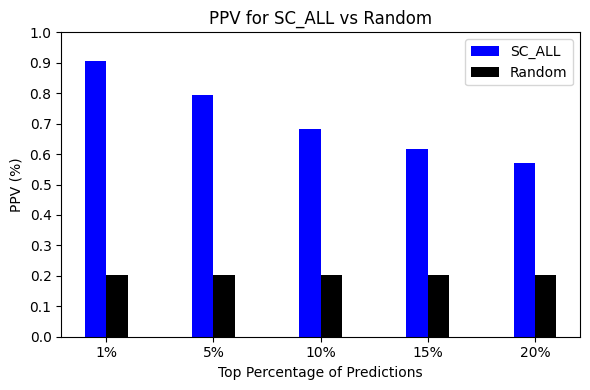

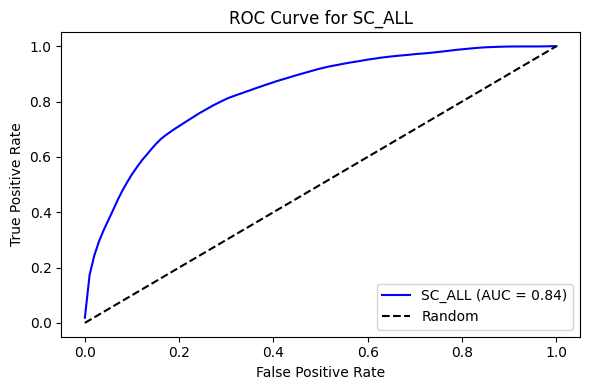

In [301]:
classifier_all = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')
classifier_all.run()



--------------------------------------------------------------------------------
Running experiment for S. cerevisiae
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.9230434782608705, PPV (5%): 0.7557627118644069
Features: 41, PPV (1%): 0.9104347826086961, PPV (5%): 0.7514406779661016
Features: 40, PPV (1%): 0.9173913043478263, PPV (5%): 0.7616101694915248
Features: 39, PPV (1%): 0.9213043478260877, PPV (5%): 0.7592372881355933
Features: 38, PPV (1%): 0.9204347826086959, PPV (5%): 0.7630508474576271
Features: 37, PPV (1%): 0.91, PPV (5%): 0.7533050847457625
Features: 36, PPV (1%): 0.9260869565217399, PPV (5%): 0.7614406779661015
Features: 35, PPV (1%): 0.9169565217

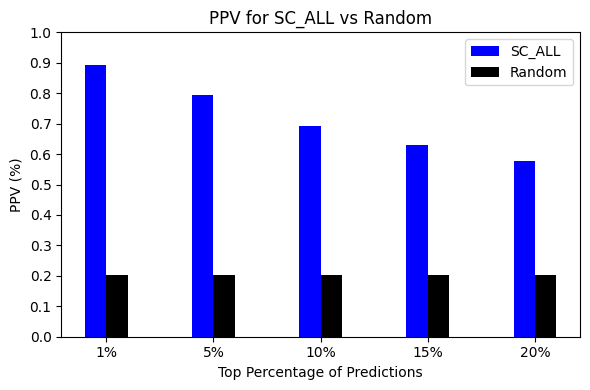

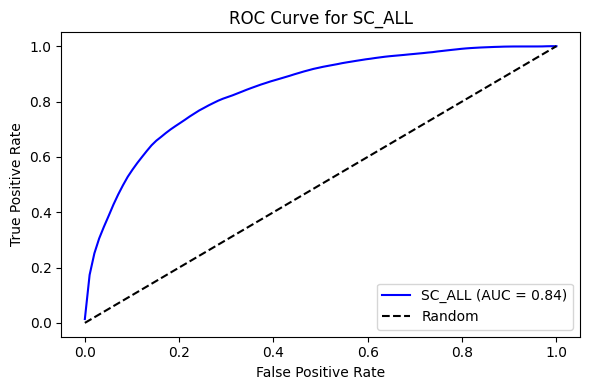

Running classifier SC_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 16, PPV (1%): 0.8095652173913043, PPV (5%): 0.654745762711864
Features: 15, PPV (1%): 0.8269565217391301, PPV (5%): 0.6788983050847455
Features: 14, PPV (1%): 0.8065217391304346, PPV (5%): 0.6609322033898302
Features: 13, PPV (1%): 0.8226086956521738, PPV (5%): 0.6766101694915255
Features: 12, PPV (1%): 0.830869565217391, PPV (5%): 0.6938135593220339
Features: 11, PPV (1%): 0.854347826086956, PPV (5%): 0.7211016949152548
Features: 10, PPV (1%): 0.8365217391304346, PPV (5%): 0.7146610169491526
Features: 9, PPV (1%): 0.8652173913043475, PPV (5%): 0.7061016949152539
Features: 8, PPV (1%): 0.8486956521739133, PPV (5%): 0.6986440677966098
Features: 7, PPV (1%): 0.823478260869565, PPV (5%): 0.6855084745762707
Features: 6, PPV (1%): 0.8226086956521734, PPV (5%): 0.687796

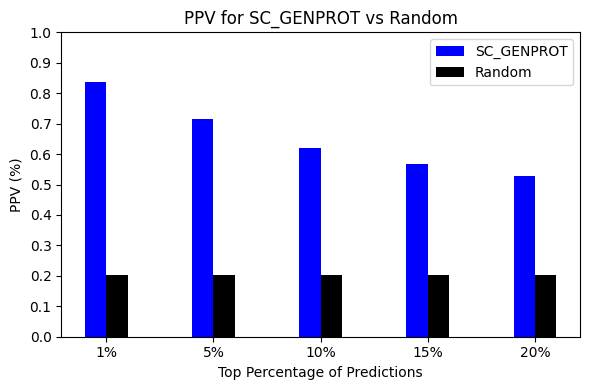

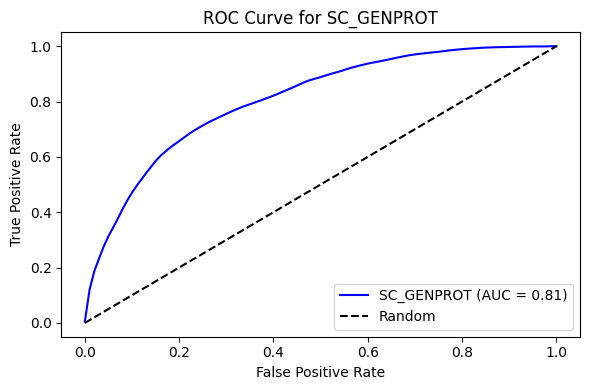

Running classifier SC_NO_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 15, PPV (1%): 0.6673913043478262, PPV (5%): 0.5275423728813561
Features: 14, PPV (1%): 0.6156521739130438, PPV (5%): 0.51864406779661
Features: 13, PPV (1%): 0.613913043478261, PPV (5%): 0.5257627118644067
Features: 12, PPV (1%): 0.5626086956521741, PPV (5%): 0.45457627118644056
Features: 11, PPV (1%): 0.5621739130434787, PPV (5%): 0.45423728813559294
Features: 10, PPV (1%): 0.5434782608695652, PPV (5%): 0.46262711864406775
Features: 9, PPV (1%): 0.4595652173913043, PPV (5%): 0.501271186440678
Features: 8, PPV (1%): 0.4686956521739131, PPV (5%): 0.5055084745762711
Features: 7, PPV (1%): 0.5091304347826087, PPV (5%): 0.5335593220338986
Features: 6, PPV (1%): 0.54, PPV (5%): 0.5418644067796613
Features: 5, PPV (1%): 0.5221739130434786, PPV (5%): 0.532627118644068

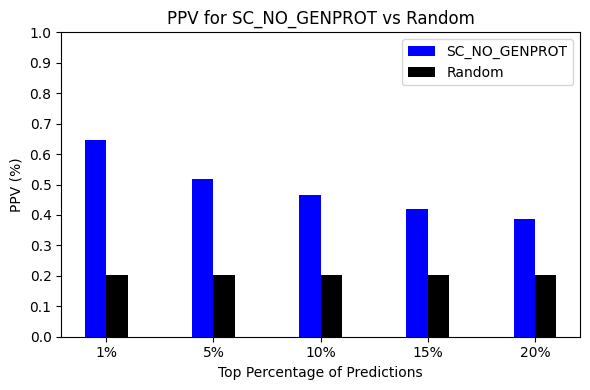

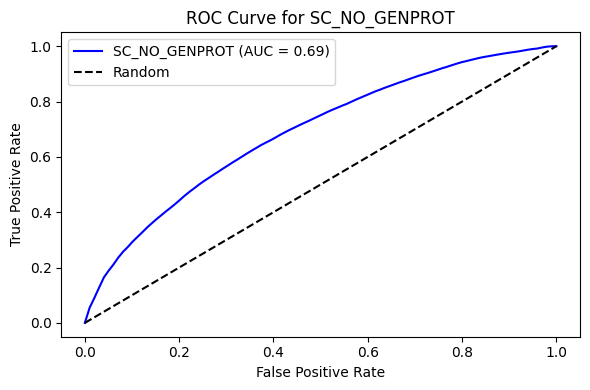

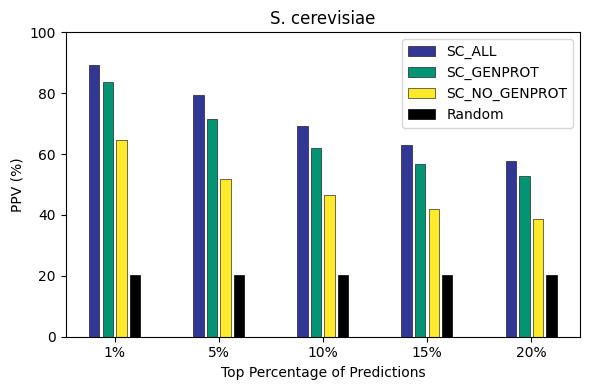

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
SC_ALL,0.89,0.8,0.69,0.63,0.58,21
SC_GENPROT,0.84,0.71,0.62,0.57,0.53,11
SC_NO_GENPROT,0.65,0.52,0.46,0.42,0.39,15


In [302]:


classifier_no_genprot_nb = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, name='SC_NO_GENPROT')
classifier_genprot_nb = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, name='SC_GENPROT')
classifier_all_nb = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae", [classifier_all_nb, classifier_genprot_nb, classifier_no_genprot_nb])
experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=COLORS)
experiment.plot_and_save_comparative_table()



In [303]:
class EssentialityRandomForestClassifier(EssentiallyClassifier):
    """
    Random Forest classifier for the essentiality prediction.
    """


    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles,name, skip_discretization=False)

        self.rf_classifiers = []  # List of Random Forest classifiers for each fold

   
    # Override
    def evaluate_model(self, X_selected):

        self.rf_classifiers = []  # Reset the list of classifiers

        k_folds = 5  # Number of folds
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)


        all_ppv = []
        all_tpr = []
        all_auc = []
        mean_fpr = np.linspace(0,1,100)

        for train_index, test_index in skf.split(X_selected, self.y):
            X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            # Build and fit the Random Forest classifier
            rf_classifier = RandomForestClassifier(
                n_estimators=100,           # Number of trees
                max_depth=15,               # Maximum depth of the tree
                min_samples_leaf=5,         # Minimum samples per leaf 
                max_features='sqrt',        # Features considered for best split
                class_weight='balanced',    # Handle imbalanced classes
                n_jobs=-1                   # Use all cores (for parallel processing)
            )
            rf_classifier.fit(X_train, y_train)

            # Predict probabilities on the test set
            y_prob = rf_classifier.predict_proba(X_test)[:, 1]

            # Calculate metrics
            ppv_iteration = self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc = roc_auc_score(y_test, y_prob)
            

            all_ppv.append(ppv_iteration)
            all_tpr.append(np.interp(mean_fpr, fpr, tpr))
            all_auc.append(auc)

            # Save the classifier 
            self.rf_classifiers.append(rf_classifier)
        
        
        mean_ppv = np.mean(all_ppv, axis=0)
        mean_tpr = np.mean(all_tpr, axis=0)
        mean_auc = np.mean(all_auc)


        return mean_ppv, mean_fpr, mean_tpr, mean_auc
    


    def plot_feature_importance(self):
        """
        Plot the feature importance of the Random Forest classifier.
        """

        # Assumiamo che self.rf_classifiers sia una lista di Random Forest usati nei vari fold
        all_importances = [clf.feature_importances_ for clf in self.rf_classifiers]

        for i, importances in enumerate(all_importances):
            print(f"Fold {i} - Feature Importances:" , len(importances), importances)


        # Converti in un array di numpy e calcola la media lungo i classificatori
        importances = np.mean(all_importances, axis=0)  
        feature_names = self.X[self.cmim_ranking].iloc[:, :self.optimal_features].columns

        plt.figure(figsize=(5, 6))  # Adjust figure size based on the number of features
        plt.barh(feature_names, importances)
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.title(f"Feature Importance in Random Forest for {self.name}")
        plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names, va='center', fontsize=10)
        plt.tight_layout()
        plt.show()

    # Extend run method to plot feature importance
    def run(self):
        super().run()
        self.plot_feature_importance()

--------------------------------------------------------------------------------
Running experiment for S. cerevisiae Random Forest
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.9111111111111111, PPV (5%): 0.8
Features: 41, PPV (1%): 0.9333333333333332, PPV (5%): 0.8127659574468085
Features: 40, PPV (1%): 0.9111111111111111, PPV (5%): 0.7872340425531915
Features: 39, PPV (1%): 0.9333333333333332, PPV (5%): 0.8085106382978724
Features: 38, PPV (1%): 0.888888888888889, PPV (5%): 0.8
Features: 37, PPV (1%): 0.8666666666666666, PPV (5%): 0.8340425531914895
Features: 36, PPV (1%): 0.888888888888889, PPV (5%): 0.7957446808510638
Features: 35, PPV (1%): 0.91111111111111

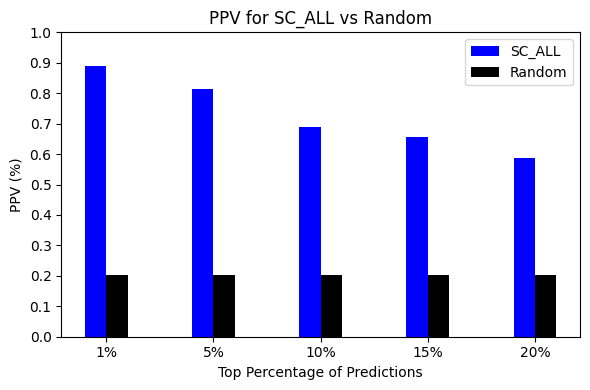

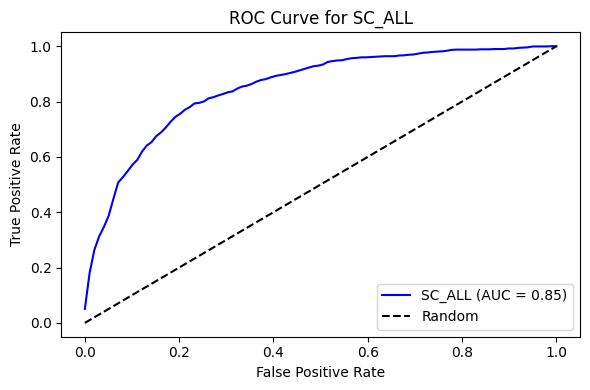

Fold 0 - Feature Importances: 37 [4.11023970e-01 6.57718550e-02 7.37570476e-02 2.32623728e-02
 4.32368005e-02 3.08788868e-02 2.31667807e-02 2.30664701e-02
 1.61738162e-02 1.71878828e-02 1.76847379e-02 3.16208141e-02
 9.17292686e-03 2.29078392e-03 1.50532414e-03 5.95359789e-03
 2.23864096e-02 2.89732122e-02 1.15095669e-02 2.45196737e-03
 1.51073237e-02 8.96085996e-03 0.00000000e+00 1.76991546e-02
 1.39962413e-04 1.64805930e-02 1.69413356e-02 3.90489960e-03
 2.74038302e-03 2.12803028e-02 4.12737564e-03 1.63026897e-02
 4.37379998e-04 2.19501804e-03 1.25668084e-02 2.73787158e-05
 1.33119382e-05]
Fold 1 - Feature Importances: 37 [3.70471072e-01 7.07821462e-02 8.87265209e-02 2.63964934e-02
 5.06451482e-02 4.19209106e-02 1.73330199e-02 2.38900493e-02
 1.65783165e-02 1.90264480e-02 1.29419243e-02 2.79302860e-02
 9.48045456e-03 3.88660801e-03 2.84719822e-03 3.99391952e-03
 2.37032642e-02 3.61786678e-02 1.39504025e-02 1.83870731e-03
 1.46306039e-02 1.13586902e-02 0.00000000e+00 1.63503451e-02
 3

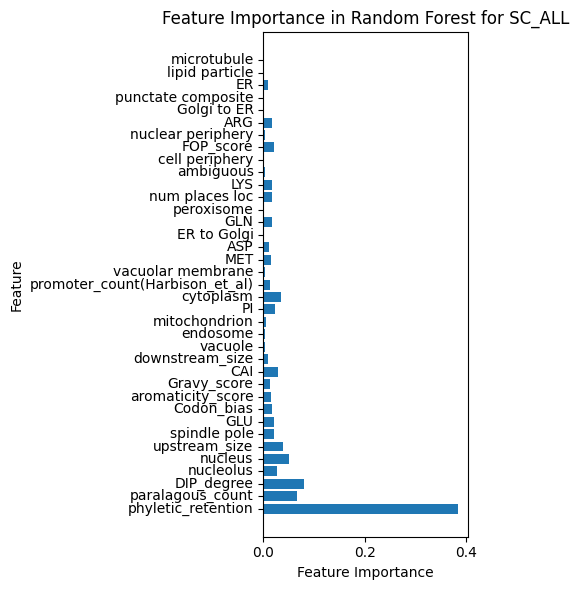

Running classifier SC_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 16, PPV (1%): 0.8222222222222222, PPV (5%): 0.7191489361702128
Features: 15, PPV (1%): 0.7777777777777777, PPV (5%): 0.7191489361702128
Features: 14, PPV (1%): 0.8, PPV (5%): 0.7106382978723403
Features: 13, PPV (1%): 0.8666666666666666, PPV (5%): 0.727659574468085
Features: 12, PPV (1%): 0.8444444444444444, PPV (5%): 0.6978723404255319
Features: 11, PPV (1%): 0.8444444444444444, PPV (5%): 0.7106382978723403
Features: 10, PPV (1%): 0.8666666666666666, PPV (5%): 0.723404255319149
Features: 9, PPV (1%): 0.8666666666666666, PPV (5%): 0.7361702127659575
Features: 8, PPV (1%): 0.8444444444444443, PPV (5%): 0.7404255319148936
Features: 7, PPV (1%): 0.7777777777777778, PPV (5%): 0.7319148936170212
Features: 6, PPV (1%): 0.8222222222222222, PPV (5%): 0.7319148936170212
Fe

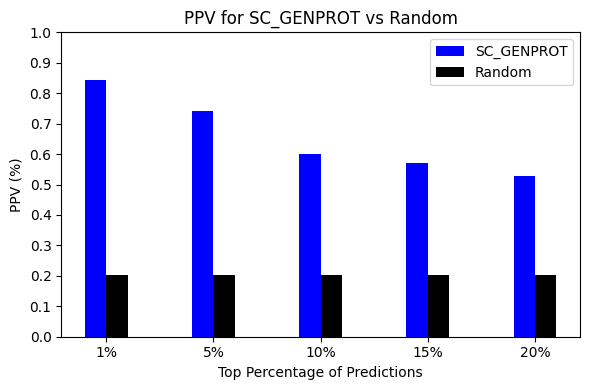

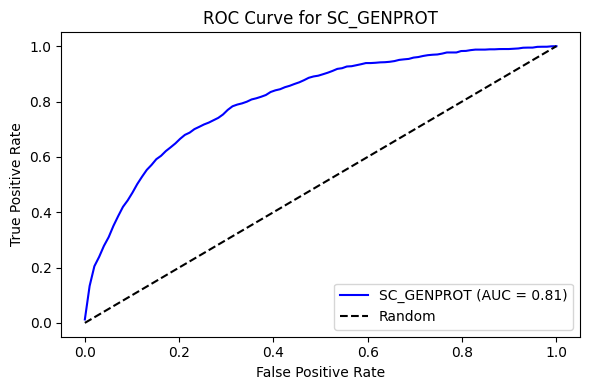

Fold 0 - Feature Importances: 8 [0.63608088 0.11415999 0.05207725 0.05779979 0.03289357 0.03330859
 0.02633768 0.04734224]
Fold 1 - Feature Importances: 8 [0.61327577 0.1215919  0.07254695 0.05310778 0.03000098 0.03446836
 0.02540377 0.04960448]
Fold 2 - Feature Importances: 8 [0.63748789 0.12019505 0.06578499 0.04853802 0.03065012 0.03062143
 0.0261823  0.04054019]
Fold 3 - Feature Importances: 8 [0.63170652 0.11111261 0.06552637 0.0487204  0.02904501 0.03183915
 0.02790975 0.0541402 ]
Fold 4 - Feature Importances: 8 [0.62161834 0.12652634 0.07536598 0.05417264 0.02923105 0.03196802
 0.01893481 0.04218283]


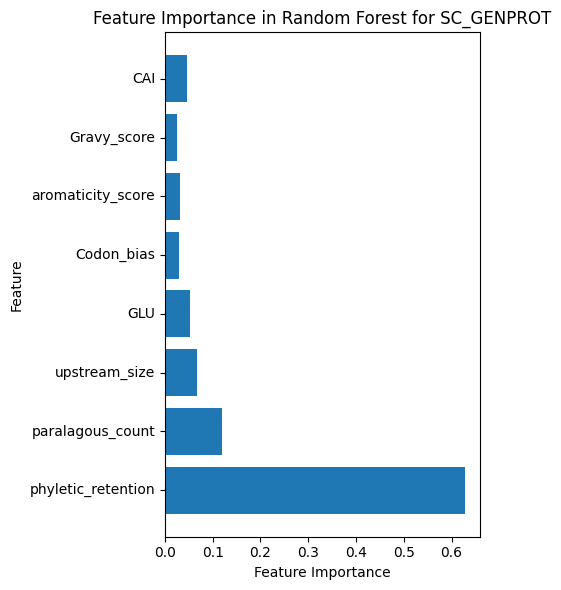

Running classifier SC_NO_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 15, PPV (1%): 0.6, PPV (5%): 0.5234042553191489
Features: 14, PPV (1%): 0.6444444444444444, PPV (5%): 0.5234042553191489
Features: 13, PPV (1%): 0.5777777777777777, PPV (5%): 0.5446808510638299
Features: 12, PPV (1%): 0.6222222222222222, PPV (5%): 0.5063829787234042
Features: 11, PPV (1%): 0.6888888888888889, PPV (5%): 0.5276595744680851
Features: 10, PPV (1%): 0.6222222222222221, PPV (5%): 0.5404255319148936
Features: 9, PPV (1%): 0.6, PPV (5%): 0.5319148936170214
Features: 8, PPV (1%): 0.5777777777777778, PPV (5%): 0.5446808510638299
Features: 7, PPV (1%): 0.6444444444444445, PPV (5%): 0.5276595744680851
Features: 6, PPV (1%): 0.6444444444444445, PPV (5%): 0.5361702127659574
Features: 5, PPV (1%): 0.6222222222222222, PPV (5%): 0.5404255319148936
Features: 4, 

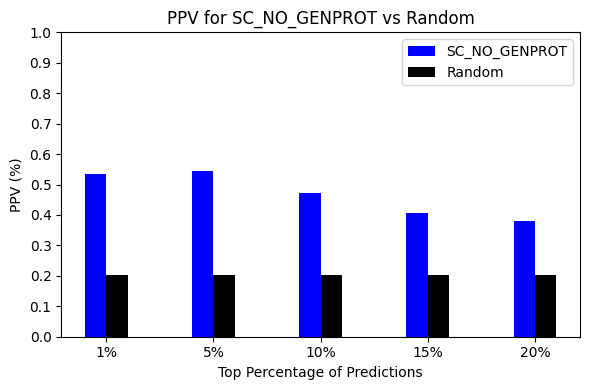

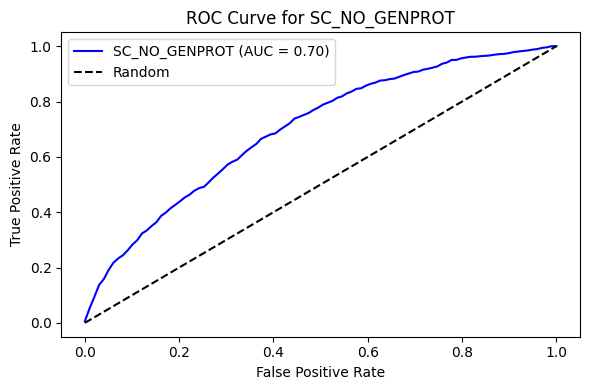

Fold 0 - Feature Importances: 13 [0.22126388 0.10434243 0.10820878 0.07565753 0.07131426 0.05302533
 0.03699192 0.05550809 0.04584463 0.02534094 0.05522899 0.05048208
 0.09679112]
Fold 1 - Feature Importances: 13 [0.22801976 0.13151425 0.09431858 0.07049899 0.07795689 0.0457345
 0.03774161 0.05699535 0.04036593 0.02765904 0.05374111 0.04829544
 0.08715855]
Fold 2 - Feature Importances: 13 [0.23665133 0.13206246 0.08848092 0.05934596 0.06171887 0.05182505
 0.0488316  0.05576663 0.04173488 0.03626148 0.05120839 0.05983784
 0.0762746 ]
Fold 3 - Feature Importances: 13 [0.20739075 0.12328117 0.10861269 0.07144696 0.07138968 0.05252768
 0.04239296 0.0555394  0.04153971 0.03000649 0.05250561 0.04967041
 0.09369648]
Fold 4 - Feature Importances: 13 [0.2382732  0.13243138 0.09222184 0.06088848 0.06466067 0.04218634
 0.0405796  0.0638123  0.04467201 0.03357687 0.0593635  0.05293905
 0.07439477]


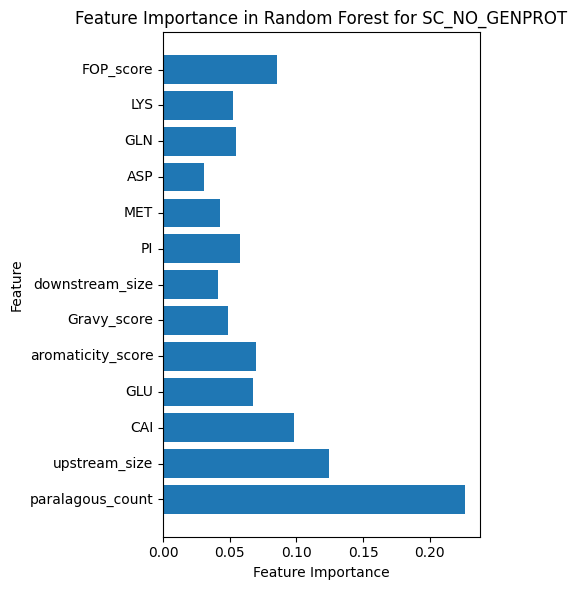

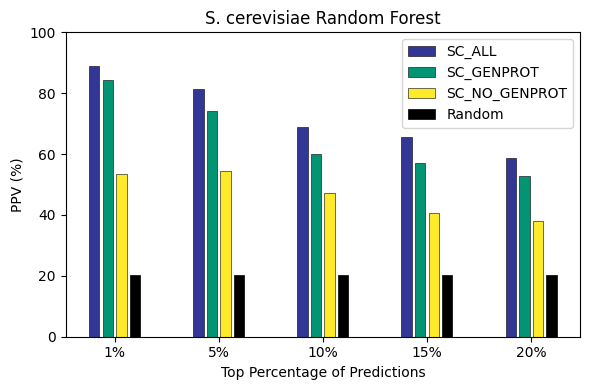

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
SC_ALL,0.89,0.81,0.69,0.66,0.59,37
SC_GENPROT,0.84,0.74,0.6,0.57,0.53,8
SC_NO_GENPROT,0.53,0.54,0.47,0.41,0.38,13


In [304]:


classifier_no_genprot_rf = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, name='SC_NO_GENPROT')
classifier_genprot_rf = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, name='SC_GENPROT')
classifier_all_rf = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae Random Forest", [classifier_all_rf, classifier_genprot_rf, classifier_no_genprot_rf])

experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=['#323694', '#039573', '#feea2a'])
experiment.plot_and_save_comparative_table()




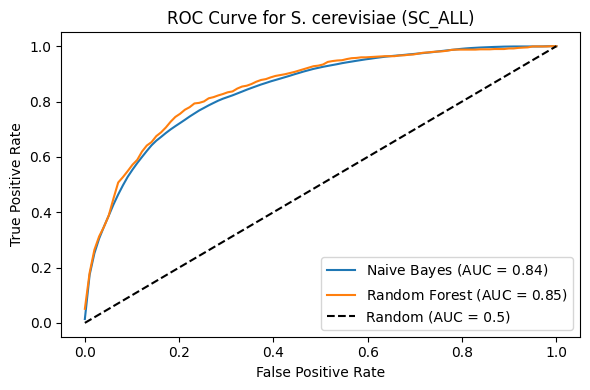

In [305]:
# Compare roc curves of naive bayes and random forest for SC_ALL
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(classifier_all_nb.final_fpr, classifier_all_nb.final_tpr, label='Naive Bayes (AUC = ${:.2f}$)'.format(classifier_all_nb.final_auc))
ax.plot(classifier_all_rf.final_fpr, classifier_all_rf.final_tpr, label='Random Forest (AUC = ${:.2f}$)'.format(classifier_all_rf.final_auc))
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for S. cerevisiae (SC_ALL)')
ax.legend()
fig.tight_layout()

